<a href="https://colab.research.google.com/github/Mainak34/Data-Science-Project-2020/blob/master/MonopoleMCMC(z%3D2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate

In [0]:
%matplotlib inline

font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('font', **font)
plt.rcParams['text.usetex'] = False

In [0]:
zz = 2.0

# Planck15 cosmology:
Om0 = 0.307
H0 = 67.7
h = 0.677

In [0]:
# Defining E(z) = H(z)/H0
def E(z):
    E2 = 1 - Om0 + Om0*pow(1+z,3)
    return np.sqrt(E2)

# Hubble constant evolving with z:
def H(z):
    return E(z)*H0

# Comoving distance to redshift z, in units Mpc
def r_comoving(z):
    c_km = 3e5 # speed of light in km per second
    func = lambda z: (c_km/H0)/E(z)
    return integrate.romberg(func,0,z)

# FWHM of telescope beam in degrees:
beam_fwhm = 0.54  #for z=2 case
# corresponding physical smoothing scale of beam, in Mpc/h:
R_beam = np.radians(beam_fwhm/(2*np.sqrt(2*np.log(2))))*r_comoving(zz)*h


In [0]:
def Beam_factor(k, R, k_FG=0):
    integral = np.zeros(len(k))
    for i in range(len(k)):
        k_i = k[i]
        if k_i==0: k_i = 1e-30 #Avoid divide by k = 0
        mu_FG = k_FG/k_i # for modelling foreground removal we use a varying mu cut, set to 0 otherwise
        if mu_FG>=1: mu_FG=0.9999999999
        mu = np.linspace(mu_FG,1,10000)
        beam_int = np.exp(-(1 - mu**2) * k[i]**2 * R**2)
        integral[i] = 2*integrate.simps(beam_int,mu)
    return 0.5*integral # (1/2) factor arising from the multipole expansion

k_perp = np.linspace(0,0.3,100) # units h/Mpc
R_beams = [1, 10, 20] # different sized beams to test, in units Mpc/h


In [0]:
# fiducial HI density, in units 10^-4:
OmHI_fid = 4.3 # from Masui et al. (2013) [arXiv:1208.0331]
# fiducial HI bias:
bHI_fid = 1

In [0]:
# loading power spectrum monopole data, and errors for both the no foreground and subtracted foreground cases:
Pk0_data = np.loadtxt('Pk0_z=2.dat', comments='#')
k, Pk0_noFG, Pk0_noFG_error, Pk0_subFG, Pk0_subFG_error = Pk0_data

In [0]:
# HI power spectrum model (monopole)

def Pk_mono(omHIbHI, beam, pdd):
    tHIbHI = 180 * h * (1+zz)**2 * 1e-4 * omHIbHI / (H(zz)/H0) # going from OmHI*bHI to tHI*bHI
    return tHIbHI**2 * beam * pdd # note that the (1/2) factor is included in the beam factor calculation

In [0]:
# beam factor:
Beam_k = Beam_factor(k, R_beam)
# underlying linear matter power spectrum, generated using nbodykit (as seen in next cell):
Pdd_k = np.loadtxt('Pk_z=2.dat', comments='#')
# calculating model:
Pk0_model = Pk_mono(OmHI_fid*bHI_fid, Beam_k, Pdd_k)

# foreground modelling with a varying mu cut:
Beam_kFG = Beam_factor(k, R_beam, k_FG=0.031)
Pk0_modelFG = Pk_mono(OmHI_fid*bHI_fid, Beam_kFG, Pdd_k)

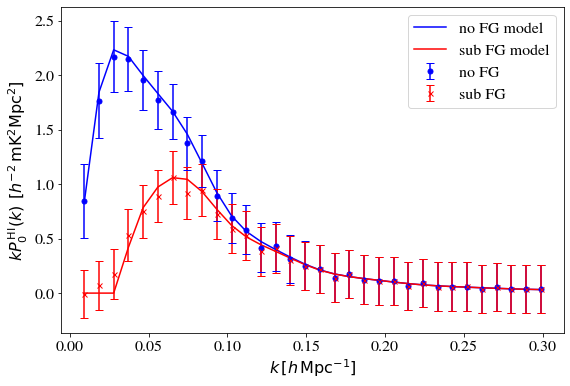

In [40]:
plt.figure(figsize=(9,6))

plt.errorbar(k, k*Pk0_noFG, yerr=k*Pk0_noFG_error, fmt='bo', capsize=4, markersize=5, label='no FG')
plt.plot(k, k*Pk0_model, c='b',label='no FG model')
plt.errorbar(k, k*Pk0_subFG, yerr=k*Pk0_subFG_error, fmt='rx', capsize=4, markersize=5, label='sub FG')
plt.plot(k, k*Pk0_modelFG, c='r',label='sub FG model')
plt.legend()
plt.xlabel(r'$k \, [h\, {\rm Mpc}^{-1}]$')
plt.ylabel("$kP^{\, \mathrm{HI}}_{0}(k)\,$ $[h^{-2}\, \mathrm{mK^2 Mpc^2}]$")

plt.show()

In [41]:
!pip install emcee

In [0]:
import emcee

# flat positivity prior:
def log_prior(theta):
    OmHIbHI = theta
    if 0 < OmHIbHI < 10000:
        return 0.0
    return -np.inf

# log probability (log likelihood + log prior):
def log_prob(theta, y, yerr, beam, pdd):
    OmHIbHI = theta # parameter we are varying
    diff = np.abs(y - Pk_mono(OmHIbHI, beam, pdd))
    ycov = np.diag(yerr**2) # diagonalise error array, assuming covariance matrix is diagonal
    ll = -0.5*np.dot(diff, np.dot(scipy.linalg.inv(ycov), diff))
    return ll + log_prior(theta) #returns likelihood times prior (posterior)

# function for running MCMC:
def run_emcee(y, yerr, beam, pdd):
    # running emcee:
    pos = [initial + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] # first proposal: initial guess + random noise
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(y, yerr, beam, pdd))
    sampler.run_mcmc(pos, nsamples) # get N samples with MCMC
    samples = sampler.chain[:, 200:, :].reshape((-1, ndim)) # discard first 200 samples (not converged yet) and flatten list
    return samples

In [0]:
# MCMC parameters:
ndim = 1 # number of parameters being probed (1, since the 2 parameters are degenerate)
nwalkers = 200 # number of walkers
nsamples = 500 # number of samples
initial = 2 # initial guess, different from true value

In [0]:
samples_noFG = run_emcee(Pk0_noFG, Pk0_noFG_error, Beam_k, Pdd_k)
samples_subFG = run_emcee(Pk0_subFG, Pk0_subFG_error, Beam_k, Pdd_k)
samples_subFG_kcut = run_emcee(Pk0_subFG[9:], Pk0_subFG_error[9:], Beam_k[9:], Pdd_k[9:]) # cuts at k=0.09 h/Mpc
samples_subFG_FGmodel = run_emcee(Pk0_subFG, Pk0_subFG_error, Beam_kFG, Pdd_k)

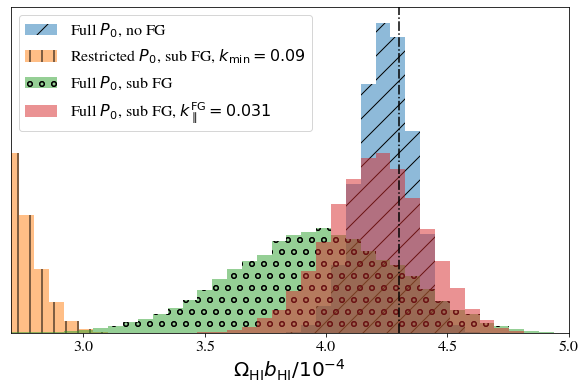

In [48]:
bins = np.linspace(2, 5, 50)

plt.figure(figsize=(10,6))

plt.hist(samples_noFG, bins, alpha=0.5, hatch='/', label='Full $P_{0}$, no FG')
plt.hist(samples_subFG, bins, alpha=0.5, hatch='|', label='Restricted $P_{0}$, sub FG, $k_{\mathrm{min}} = 0.09$')
plt.hist(samples_subFG_kcut, bins, alpha=0.5, hatch='o', label='Full $P_{0}$, sub FG')
plt.hist(samples_subFG_FGmodel, bins, alpha=0.5, label='Full $P_{0}$, sub FG, $k^\mathrm{FG}_{\parallel} = 0.031$')
plt.yticks([],[])
plt.xlim(2.7, 5)
plt.axvline(OmHI_fid*bHI_fid, c='k', ls='dashdot')
plt.legend()
plt.xlabel("$\Omega_{\mathrm{HI}}b_{\mathrm{HI}} / 10^{-4} $", fontsize=20)

plt.show()